# MIMIC NLP

>Use NLP technologies to extract entities from medical notes data. To receive full credit, your project should yield Spacy and SciSpacy extracted entities, word2vec, and tSNE plots. See the rubric below for more information. 


In [ ]:
# Github link: https://github.com/Owenx25/UT_AiInHealthcare/tree/main/MIMIC_NLP

import pandas as pd
from tqdm import tqdm
import os
import random
import spacy

DATA_PATH = '/Users/owenmccormack/Desktop/Grad_School_Projects/Spring_2025/AI_In_Healthcare/Assignments/MIMIC_NLP/data'

## Part 1: Extracting MIMIC III Data from CSV

In [2]:
# load d_icd_diagnoses.csv and diagnoses_icd.csv
d_icd_diagnoses = pd.read_csv(f'{DATA_PATH}/d_icd_diagnoses.csv')
diagnoses_icd = pd.read_csv(f'{DATA_PATH}/diagnoses_icd.csv')

ICD9_CODES = ['27652', '79902'] # '27652' is hypovolemia, '79902' is hypoxemia

In [3]:
chunksize = 10000  # Adjust based on memory
filtered_data = []

# load the notes data in chunks
for chunk in pd.read_csv(f"{DATA_PATH}/NOTEEVENTS.csv", usecols=['CATEGORY', 'TEXT', 'HADM_ID'], chunksize=chunksize):
    filtered_chunk = chunk[chunk["CATEGORY"] == "Discharge summary"]
    
    filtered_data.append(filtered_chunk)

notes_df = pd.concat(filtered_data, ignore_index=True)

# merge the notes data with the diagnoses data
notes_df = notes_df.merge(diagnoses_icd, on='HADM_ID')
notes_df = notes_df.merge(d_icd_diagnoses, on='ICD9_CODE')

# Filter to only disease codes of interest
notes_df = notes_df[notes_df['ICD9_CODE'].isin(ICD9_CODES)]

notes_df = notes_df[['TEXT', 'ICD9_CODE', 'SHORT_TITLE']]
notes_df = notes_df.reset_index(drop=True)

In [5]:
notes_df.head()

,TEXT,ICD9_CODE,SHORT_TITLE
0,Admission Date: [**2131-6-28**] ...,27652,Hypovolemia
1,Admission Date: [**2131-7-5**] D...,27652,Hypovolemia
2,Admission Date: [**2174-2-12**] ...,27652,Hypovolemia
3,Admission Date: [**2136-4-4**] D...,27652,Hypovolemia
4,Admission Date: [**2180-10-29**] ...,27652,Hypovolemia


## Part 2: Data cleaning on notes

In [6]:
# Preprocess the notes
# Remove newlines and blank lines
def extract_notes(note):
    doc = nlp(note)
    tokens = [token.lemma_ for token in doc if (token.is_alpha or token.is_digit) and not (token.is_punct or token.is_stop)]
    processed_note = ' '.join(tokens)
    return processed_note

tqdm.pandas()

In [ ]:
# cap to first 100 for testing
#notes_df = notes_df.head(100)

# load df from csv if it exists
if os.path.exists(f'{DATA_PATH}/filtered_notes.csv'):
    notes_df = pd.read_csv('filtered_notes.csv')
else:
    print("Applying tokenization to notes...")
    notes_df['CLEAN_TEXT'] = notes_df['TEXT'].progress_apply(extract_notes)
    #notes_df = notes_df.drop(columns=['TEXT'])
    # write to file
    notes_df.to_csv(f'{DATA_PATH}/filtered_notes.csv', index=False)

## Part 3: Using Spacy to load named entities

In [ ]:
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
# example of the entities from a random note
i = random.randint(0, len(notes_df))
doc = nlp(notes_df['CLEAN_TEXT'][i])

displacy.render(doc, style="ent", jupyter=True)

## Part 4: Using SciSpacy to identify named entities

In [ ]:
nlp = spacy.load("en_core_sci_sm")
# example of the entities from a random note
doc = nlp(notes_df['CLEAN_TEXT'][i])

displacy.render(doc, style="ent", jupyter=True)

## Part 5: Medspacy Entities

In [223]:
import medspacy

nlp = medspacy.load()
if "medspacy_target_matcher" not in nlp.pipe_names:
    target_matcher = nlp.add_pipe("medspacy_target_matcher")
else:
    target_matcher = nlp.get_pipe("medspacy_target_matcher")

from medspacy.ner import TargetRule

target_rules = [
    TargetRule("hypoxemia", "DIAGNOSIS"),
    TargetRule("hypovolemia", "DIAGNOSIS"),
    TargetRule("fluid", "SUBSTANCE"),
    TargetRule("oxygen", "SUBSTANCE"),
    TargetRule("blood", "SUBSTANCE"),
    TargetRule("hypertension", "PROBLEM"),
    TargetRule("Hemoptysis", "SYMPTOM"),
    TargetRule("Iodine", "MEDICINE"),
    TargetRule("Chemotherapy", "TREATMENT"),
    TargetRule("Chronic kidney disease", "DIAGNIOSIS")
]

target_matcher.add(target_rules)

In [224]:
# Try tokenizing a random note
from medspacy.preprocess import PreprocessingRule, Preprocessor

preprocessor = Preprocessor(nlp.tokenizer)
nlp.tokenizer = preprocessor

preprocess_rules = [
    
    PreprocessingRule(
        r"\[\*\*[\d]{1,4}-[\d]{1,2}(-[\d]{1,2})?\*\*\]",
        repl="01-01-2010",
        desc="Replace MIMIC date brackets with a generic date."
    ),
    
    PreprocessingRule(
        r"\[\*\*[\d]{4}\*\*\]",
        repl="2010",
        desc="Replace MIMIC year brackets with a generic year."
    ),
    
    PreprocessingRule(
        r"dx'd", 
        repl="Diagnosed", 
        desc="Replace abbreviation"
    ),
    
    PreprocessingRule(
        r"tx'd", 
        repl="Treated", 
        desc="Replace abbreviation"
    ),
    
    PreprocessingRule(
        r"\[\*\*[^\]]+\]", 
        desc="Remove all other bracketed placeholder text from MIMIC"
    )
]

preprocessor.add(preprocess_rules)

sectionizer = nlp.add_pipe("medspacy_sectionizer")

i = random.randint(0, len(notes_df))
doc = nlp(notes_df['TEXT'][i])


In [ ]:
from medspacy.visualization import visualize_ent
# example of the entities from a random note

visualize_ent(doc)

## Part 6: Word2Vec for both diseases

In [8]:
import gensim
from gensim.models import Word2Vec

In [19]:
# Build corpus for word2vec for each disease
corpus_hypoxemia = []
corpus_hypovolemia = []
for index, row in notes_df.iterrows():
    if row['ICD9_CODE'] == 79902:
        corpus_hypoxemia.append(row['CLEAN_TEXT'].split())
    else:
        corpus_hypovolemia.append(row['CLEAN_TEXT'].split())

# Train the model
print("Training Word2Vec model...")
hypoxemia_model = Word2Vec(corpus_hypoxemia, vector_size=100, window=5, min_count=1, workers=4)
hypovolemia_model = Word2Vec(corpus_hypovolemia, vector_size=100, window=5, min_count=1, workers=4)

Training Word2Vec model...


In [26]:
hypoxemia_model.wv['oxygen']

array([ 0.03895087, -1.1207881 ,  1.5528256 , -2.7331047 , -0.30126965,
        1.0726908 ,  0.08480167, -0.47808793, -0.01128795, -0.03852274,
        0.6617437 ,  0.59923923, -0.61934483, -1.8857619 , -0.51641655,
        0.13195938,  0.5695087 , -2.8020847 , -1.473246  , -0.3932221 ,
       -1.1718646 , -1.5152743 ,  1.0699512 ,  0.6776517 , -0.47865844,
       -1.4680332 , -0.9456355 , -1.8908291 , -0.10760301, -0.4123535 ,
        2.5157337 , -0.84809685, -0.5621743 ,  0.94553566, -2.248193  ,
        0.22697856,  1.4085568 ,  0.19325346, -1.5455273 , -0.9581423 ,
        2.642955  ,  1.312176  , -3.344484  ,  1.7989054 , -0.3003303 ,
        0.09314188,  0.79582435, -0.10538127,  0.97018856,  2.1060913 ,
        1.0508069 ,  0.9102978 ,  1.790369  ,  1.314846  ,  2.4714775 ,
        3.7053497 ,  0.07047264,  0.69047046,  0.06314296,  1.0829582 ,
        1.758184  ,  1.7061936 ,  0.28644338, -0.5770909 , -2.9254375 ,
       -2.4447272 , -1.3639472 ,  0.48078507, -1.9972608 ,  1.03

In [ ]:
hypoxemia_model.wv.most_similar('oxygen')
#hypoxemia_model.wv['hypoxemia']

[('hypoxia', 0.9234226942062378),
 ('Hypoxia', 0.8711618781089783),
 ('tachypnea', 0.8167559504508972),
 ('transient', 0.8122639656066895),
 ('delirium', 0.8085092306137085),
 ('hypercarbia', 0.8020545840263367),
 ('ams', 0.7874382734298706),
 ('hypotension', 0.7849908471107483),
 ('hyponatremia', 0.7734580636024475),
 ('exacerbation', 0.7643312215805054)]

In [28]:
hypovolemia_model.wv['blood']

array([ 2.4695919e+00,  5.7430381e-01, -4.9260069e-02,  2.7330978e+00,
        8.4703043e-02, -2.5638869e+00, -1.2581259e+00,  2.0674965e+00,
        1.2745624e+00,  4.6179733e-01, -2.6710898e-01,  1.4202897e-01,
       -1.0124478e+00,  2.3148406e+00, -7.3468886e-02,  1.0450095e+00,
        1.0330912e+00,  2.3318137e-01, -2.0151381e+00,  8.3300149e-01,
       -1.2469852e+00,  1.6715105e+00, -2.0760450e+00,  3.1830649e+00,
        1.5870173e-01, -7.9714578e-01, -1.8865231e-01,  1.3763421e+00,
       -3.9087710e-01,  4.7805756e-01,  1.1210032e-01, -2.4237614e+00,
       -6.9727665e-01, -1.0782248e+00,  1.3080304e+00, -2.3333214e-01,
       -7.6095873e-01, -1.3692631e+00, -7.9895008e-01,  9.2514582e-02,
       -3.6084706e-01,  9.0318477e-01, -2.2972293e+00,  4.6188572e-01,
        2.6300974e+00, -4.5941961e-01, -1.4781646e+00, -9.1675329e-01,
       -1.3503810e+00, -6.0092396e-01,  2.8127404e-03,  1.8822728e+00,
       -5.4893082e-01, -6.3782918e-01, -3.1161907e+00,  1.0002286e+00,
      

In [ ]:
hypovolemia_model.wv.most_similar('blood')
#hypoxemia_model.wv['hypovolemia']

[('hypovolemic', 0.8736305236816406),
 ('prerenal', 0.8492504358291626),
 ('hyponatremia', 0.8473820686340332),
 ('depletion', 0.8374687433242798),
 ('hypernatremia', 0.8278751373291016),
 ('dehydration', 0.8269059658050537),
 ('ATN', 0.8260441422462463),
 ('ARF', 0.8184607028961182),
 ('hypoperfusion', 0.8047881722450256),
 ('cardiogenic', 0.7947381734848022)]

# Part 7: TSNE Plots

In [32]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def tsne_plot(model, words, preTrained=False, num_points=100):
    labels = []
    tokens = []

    if preTrained:
        for word in words:
            tokens.append(model[word])
            labels.append(word)
    else:
        for word in words:
            tokens.append(model.wv[word])
            labels.append(word)
    tokens = np.array(tokens)

    # sample a subset of the data
    if len(tokens) > num_points:
        indices = random.sample(range(len(tokens)), num_points)
        tokens = tokens[indices]
        labels = [labels[i] for i in indices]

    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/owenmccormack/Desktop/Grad_School_Projects/Spring_2025/AI_In_Healthcare/Assignments/MIMIC_NLP/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


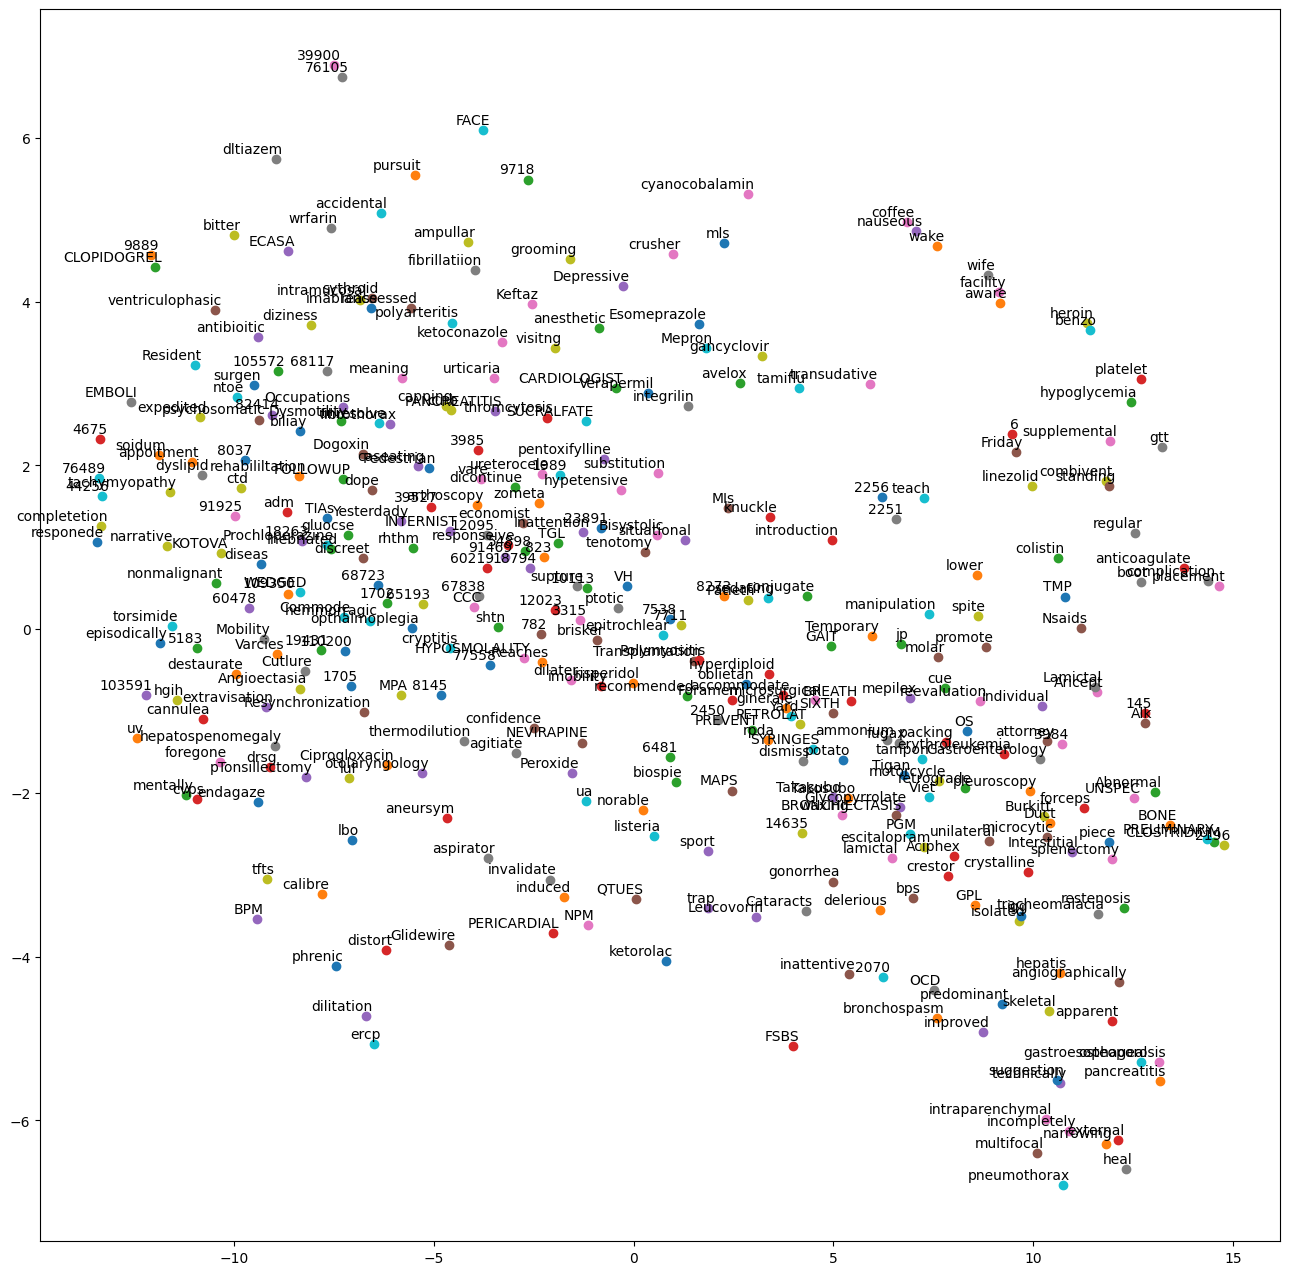

In [40]:
vocabs = hypoxemia_model.wv.key_to_index.keys()
new_v = np.array(list(vocabs))
tsne_plot(hypoxemia_model, new_v, num_points=350)

/Users/owenmccormack/Desktop/Grad_School_Projects/Spring_2025/AI_In_Healthcare/Assignments/MIMIC_NLP/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


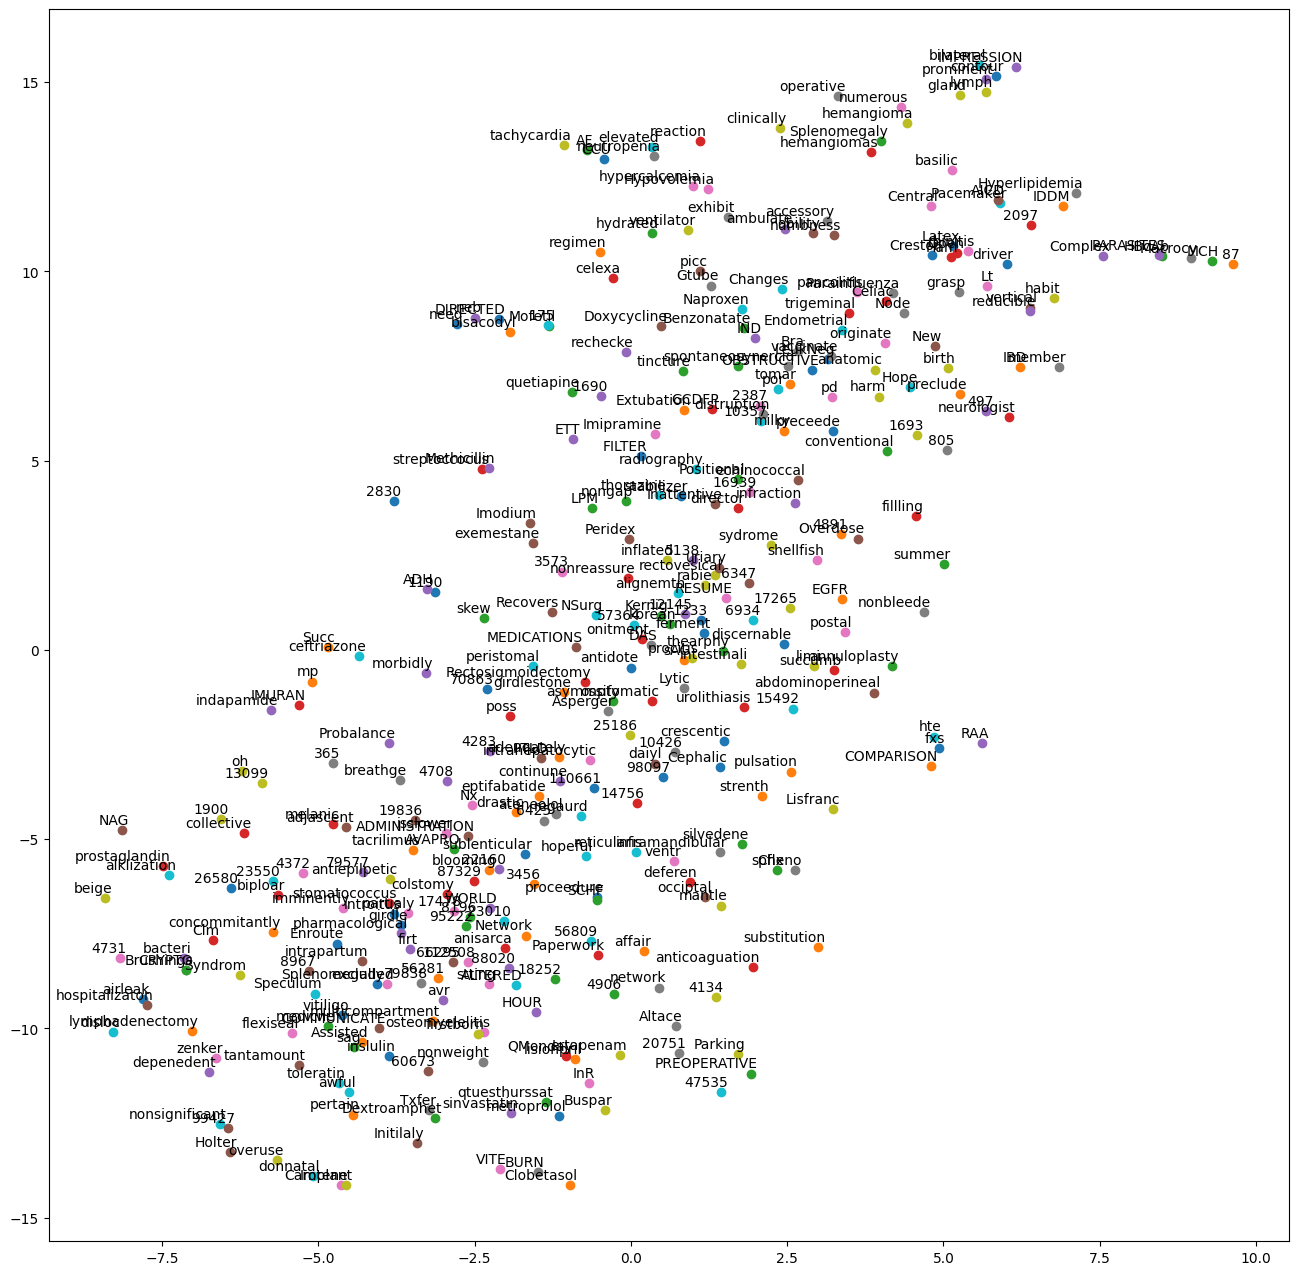

In [41]:
vocabs = hypovolemia_model.wv.key_to_index.keys()
new_v = np.array(list(vocabs))
tsne_plot(hypovolemia_model, new_v, num_points=350)